In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from copy import deepcopy
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from sklearn.metrics import r2_score
import sys

sys.path.append('..')
from data_utils import *

sys.path.append('../../DeLASE')
from delase import *
from parameter_choosing import *
from performance_metrics import *

# Load Data

In [3]:
chaotic_net_path = "/scratch2/weka/millerlab/eisenaj/DynamicalTrajectories/chaotic_net_data"

W = pd.read_pickle(os.path.join(chaotic_net_path, "W.pkl"))
lyaps = pd.read_pickle(os.path.join(chaotic_net_path, "lyaps_long.pkl"))
full_signals = pd.read_pickle(os.path.join(chaotic_net_path, "chaotic_net_signals_long.pkl"))

In [4]:
N = list(full_signals.values())[0].shape[2]
T = list(full_signals.values())[0].shape[1]
dt = 0.01

In [9]:
# noise_sd = 0.1
noise_sd = 0
normalize = False
# indices = np.random.choice(np. arange(N), size=(50,), replace=False)
indices = pd.read_pickle(os.path.join(chaotic_net_path, "indices.pkl"))
signals = {}
for key in full_signals.keys():
    signals[key] = full_signals[key][0][:, indices] 
    if normalize:
        signals[key] = (signals[key] - signals[key].mean())/signals[key].std()
    signals[key] += np.random.randn(T, len(indices))*noise_sd

# Parameter Picking

In [354]:
parameter_grid = ParameterGrid(
    window_vals=np.array([10000]),
    matrix_size_vals=np.array([550]),
#     explained_variance_vals=np.array([0.5, 0.7, 0.8, 0.85, 0.9, 0.95, 0.97, 0.99, 0.995, 0.999, 0.9999]),
    r_vals=np.array([100, 200, 500, 750, 1000, 1500, 2000, 2500, 3000]),
#     r_vals=np.array([10, 25, 50, 75, 100, 200, 300, 400, 500]),
    lamb_vals=np.array([0, 1e-12, 1e-8, 1e-3, 1e-2, 1e-1, 0.5]),
    reseed_vals=np.array([1, 5, 10, 15, 20, 30, 40, 50, 100, 150, 200, 250, 300, 400, 500, 750, 1000])
#     reseed_vals=np.array([1, 5, 10, 15])
)

In [355]:
prediction_time = 3000

In [356]:
results = {}
transient = 2000
for key, signal in signals.items():
    if key >= 1.1:
        print("-"*50)
        print(f"g = {key}")
        print("-"*50)

        window = parameter_grid.window_vals[0]

    #     signal = (signal - signal.mean())/signal.std()

        train_signal = signal[transient:transient + window]
        test_signal = signal[transient + window:transient + window + prediction_time]

        results[key] = parameter_search(train_signal, test_signal, parameter_grid, dt=dt, verbose=True, use_torch=True, device='cuda')

--------------------------------------------------
g = 1.1
--------------------------------------------------


  0%|          | 0/1071 [00:00<?, ?it/s]

--------------------------------------------------
g = 1.3
--------------------------------------------------


  0%|          | 0/1071 [00:00<?, ?it/s]

--------------------------------------------------
g = 1.4
--------------------------------------------------


  0%|          | 0/1071 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



--------------------------------------------------
g = 1.8
--------------------------------------------------


  0%|          | 0/1071 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
pd.to_pickle(results, os.path.join(chaotic_net_path, "chaotic_nets_grid_search_df_unnormed_over_r_SMALLMAT_BIGWINDOW.pkl"))
# results = pd.read_pickle(os.path.join(chaotic_net_path, "chaotic_nets_grid_search_df_unnormed_over_r_SMALLMAT.pkl"))

# PLOT A CORRELATION OF TOP 0.1 and TOP10 STAB WITH ML as a FUNCTION OF R_THRESH

In [53]:
keys = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8]
# keys = list(results.keys())
# lamb = 1e-3
lamb = 0
top_percent = 0.001

mean_over_r_thresh_vals = []
r_thresh_vals = results[keys[0]][results[keys[0]].lamb == lamb].r_thresh
for key in keys:
    mean_over_r_thresh_vals.append(results[key][results[key].lamb == lamb].stability_params.apply(lambda x: x[:int(top_percent*len(x))].mean()).to_numpy())
mean_over_r_thresh_vals = np.array(mean_over_r_thresh_vals)

lyap_correls = [scipy.stats.pearsonr(mean_over_r_thresh_vals[:, i], [lyaps[key][:1].mean() for key in keys])[0] for i in range(mean_over_r_thresh_vals.shape[1])]
lyap_r2 = [r2_score(mean_over_r_thresh_vals[:, i], [lyaps[key][:1].mean() for key in keys]) for i in range(mean_over_r_thresh_vals.shape[1])]

AttributeError: 'DataFrame' object has no attribute 'r_thresh'

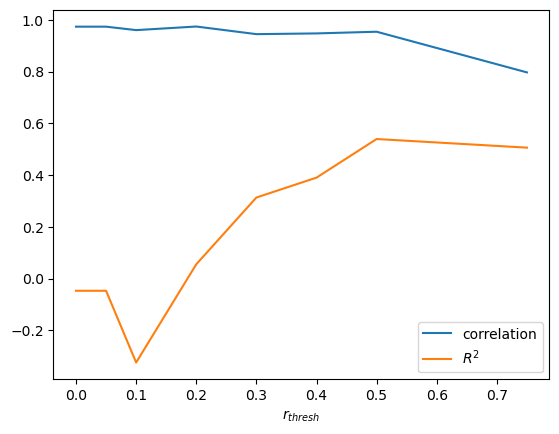

In [42]:
start = 0
end = 11
plt.plot(r_thresh_vals.iloc[start:end], lyap_correls[start:end], label='correlation')
plt.plot(r_thresh_vals.iloc[start:end], lyap_r2[start:end], label='$R^2$')
plt.legend()
plt.xlabel('$r_{thresh}$')
plt.show()

# Plot All Combos

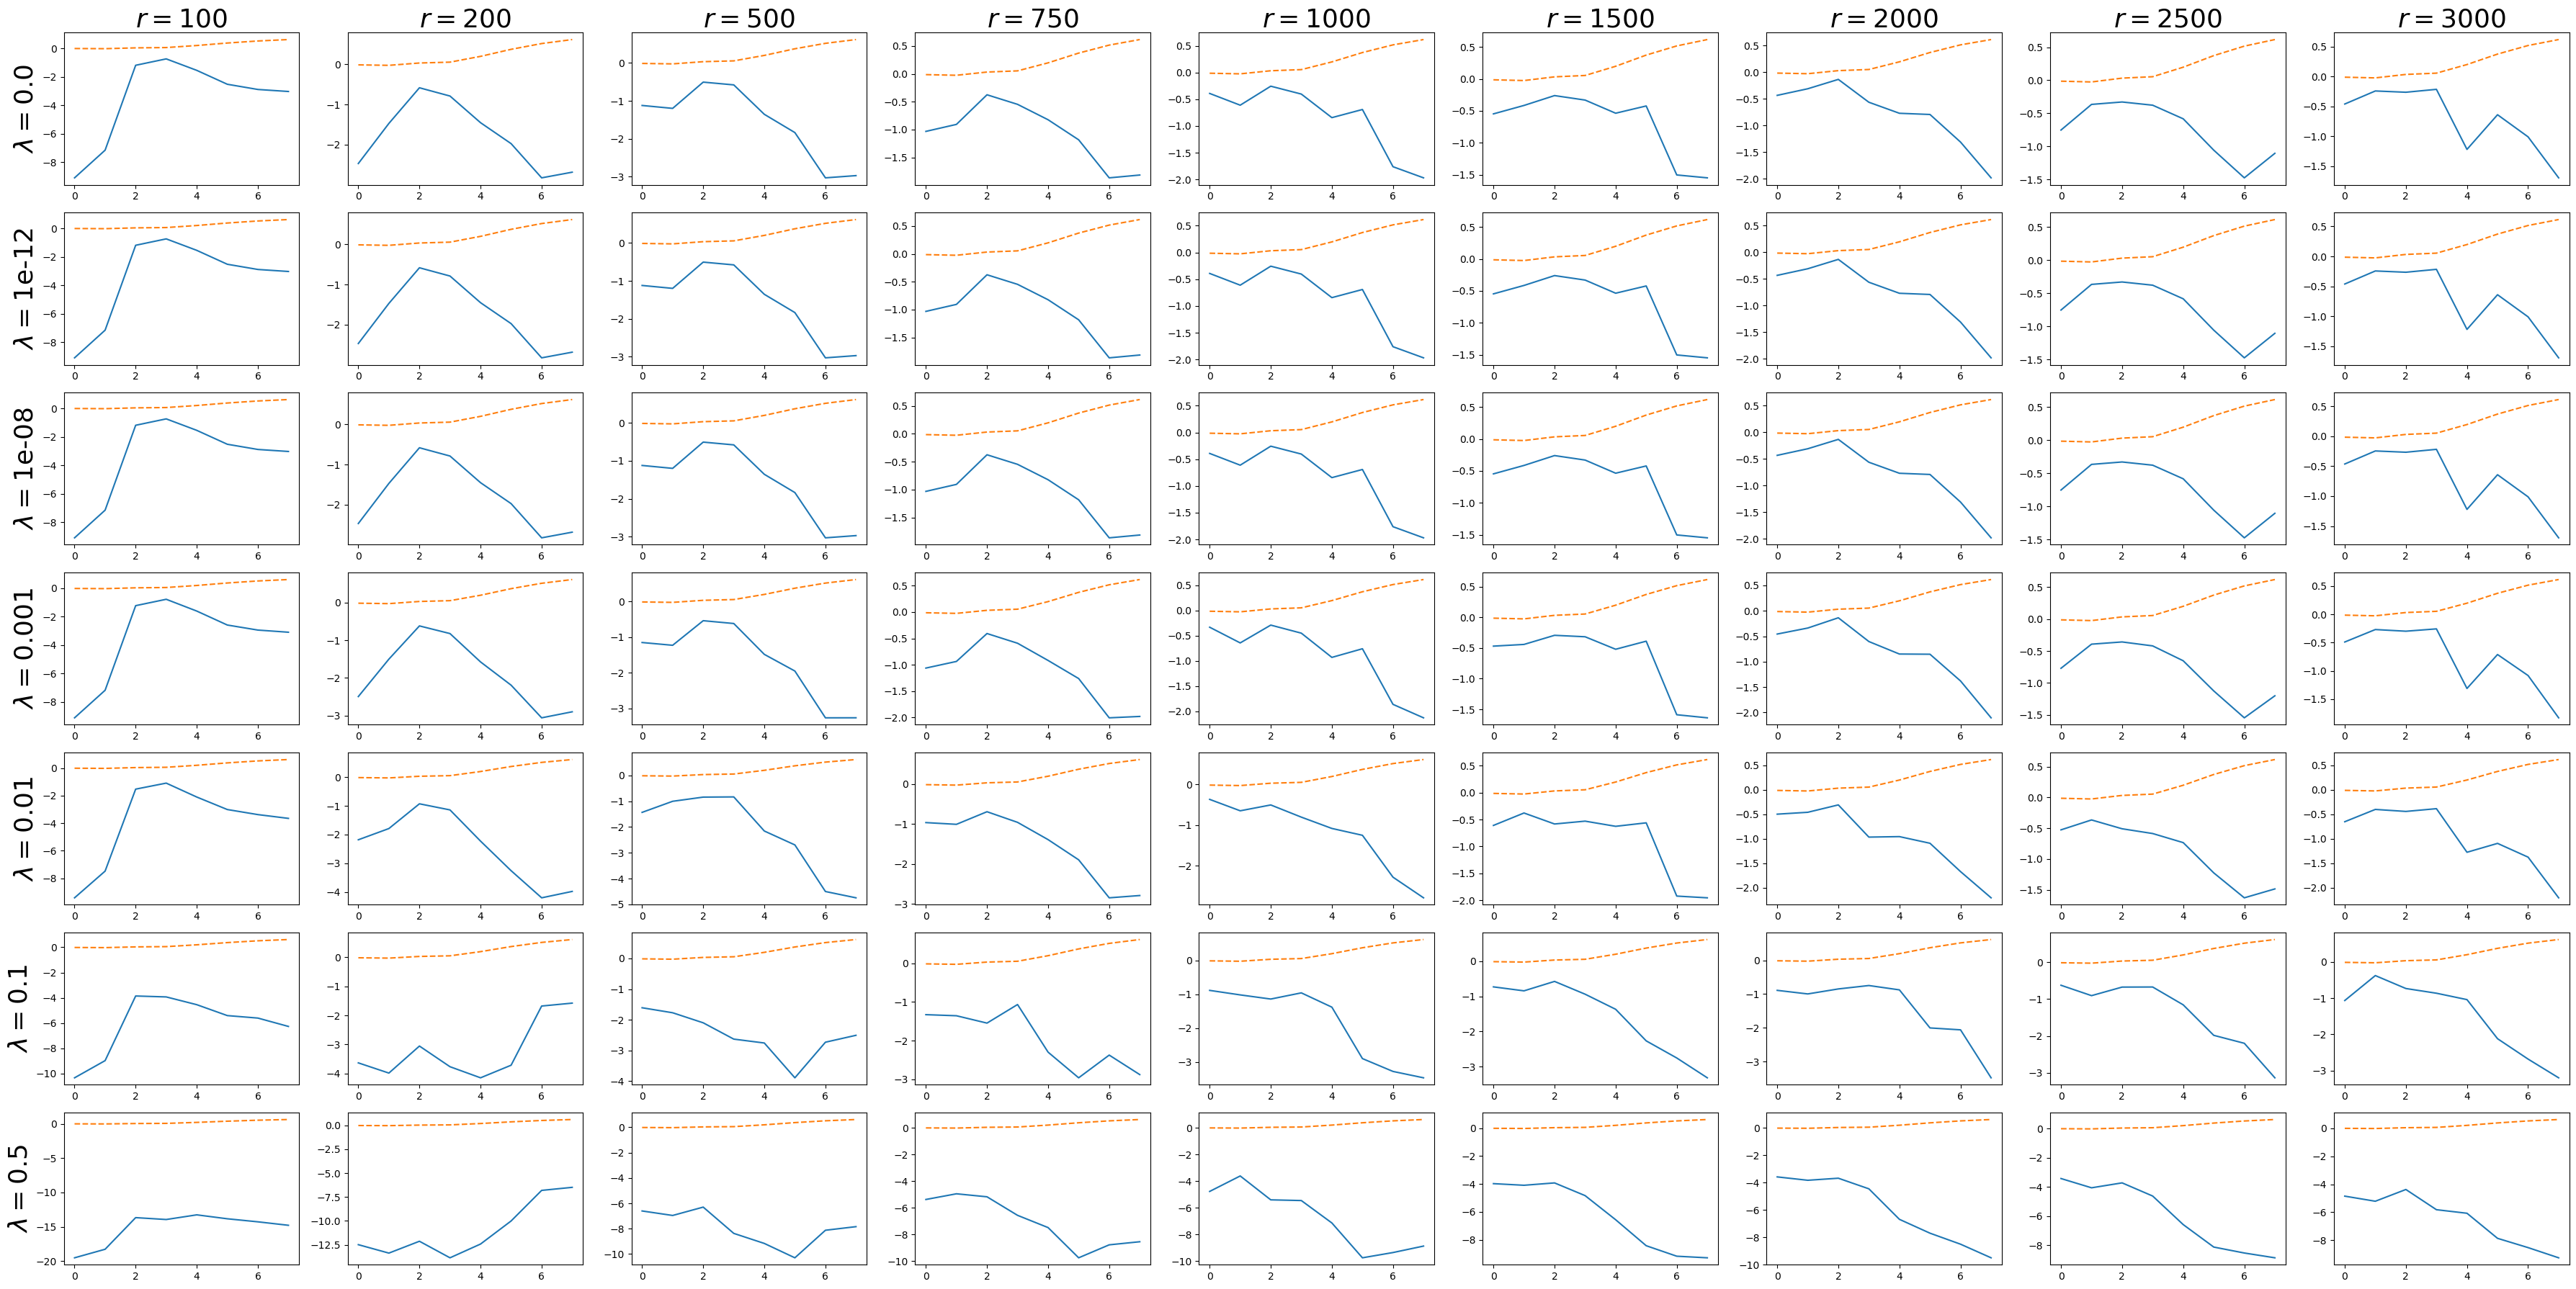

In [272]:
keys = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8]
top_percent = 0.01
r_vals = results[keys[0]].r.unique()
lamb_vals = results[keys[0]].lamb.unique()

fig, axs = plt.subplots(len(lamb_vals), len(r_vals), figsize=(36, 18))
for i, r in enumerate(r_vals):
    for j, lamb in enumerate(lamb_vals):
        curve = [results[key][np.logical_and(results[key].r == r, results[key].lamb == lamb)].stability_params.apply(lambda x: x[:int(top_percent*len(x))].mean()).to_numpy()[0] for key in keys]
        ax = axs[j, i]
        ax.plot(curve)
        ax.plot([lyaps[key][:1].mean() for key in keys], linestyle='--', c='C1')
        if i == 0:
            ax.set_ylabel(f"$\lambda = ${lamb}", fontsize=26)
        if j == 0:
            ax.set_title("$r = $" + f"{r}", fontsize=26)
plt.tight_layout()
plt.show()

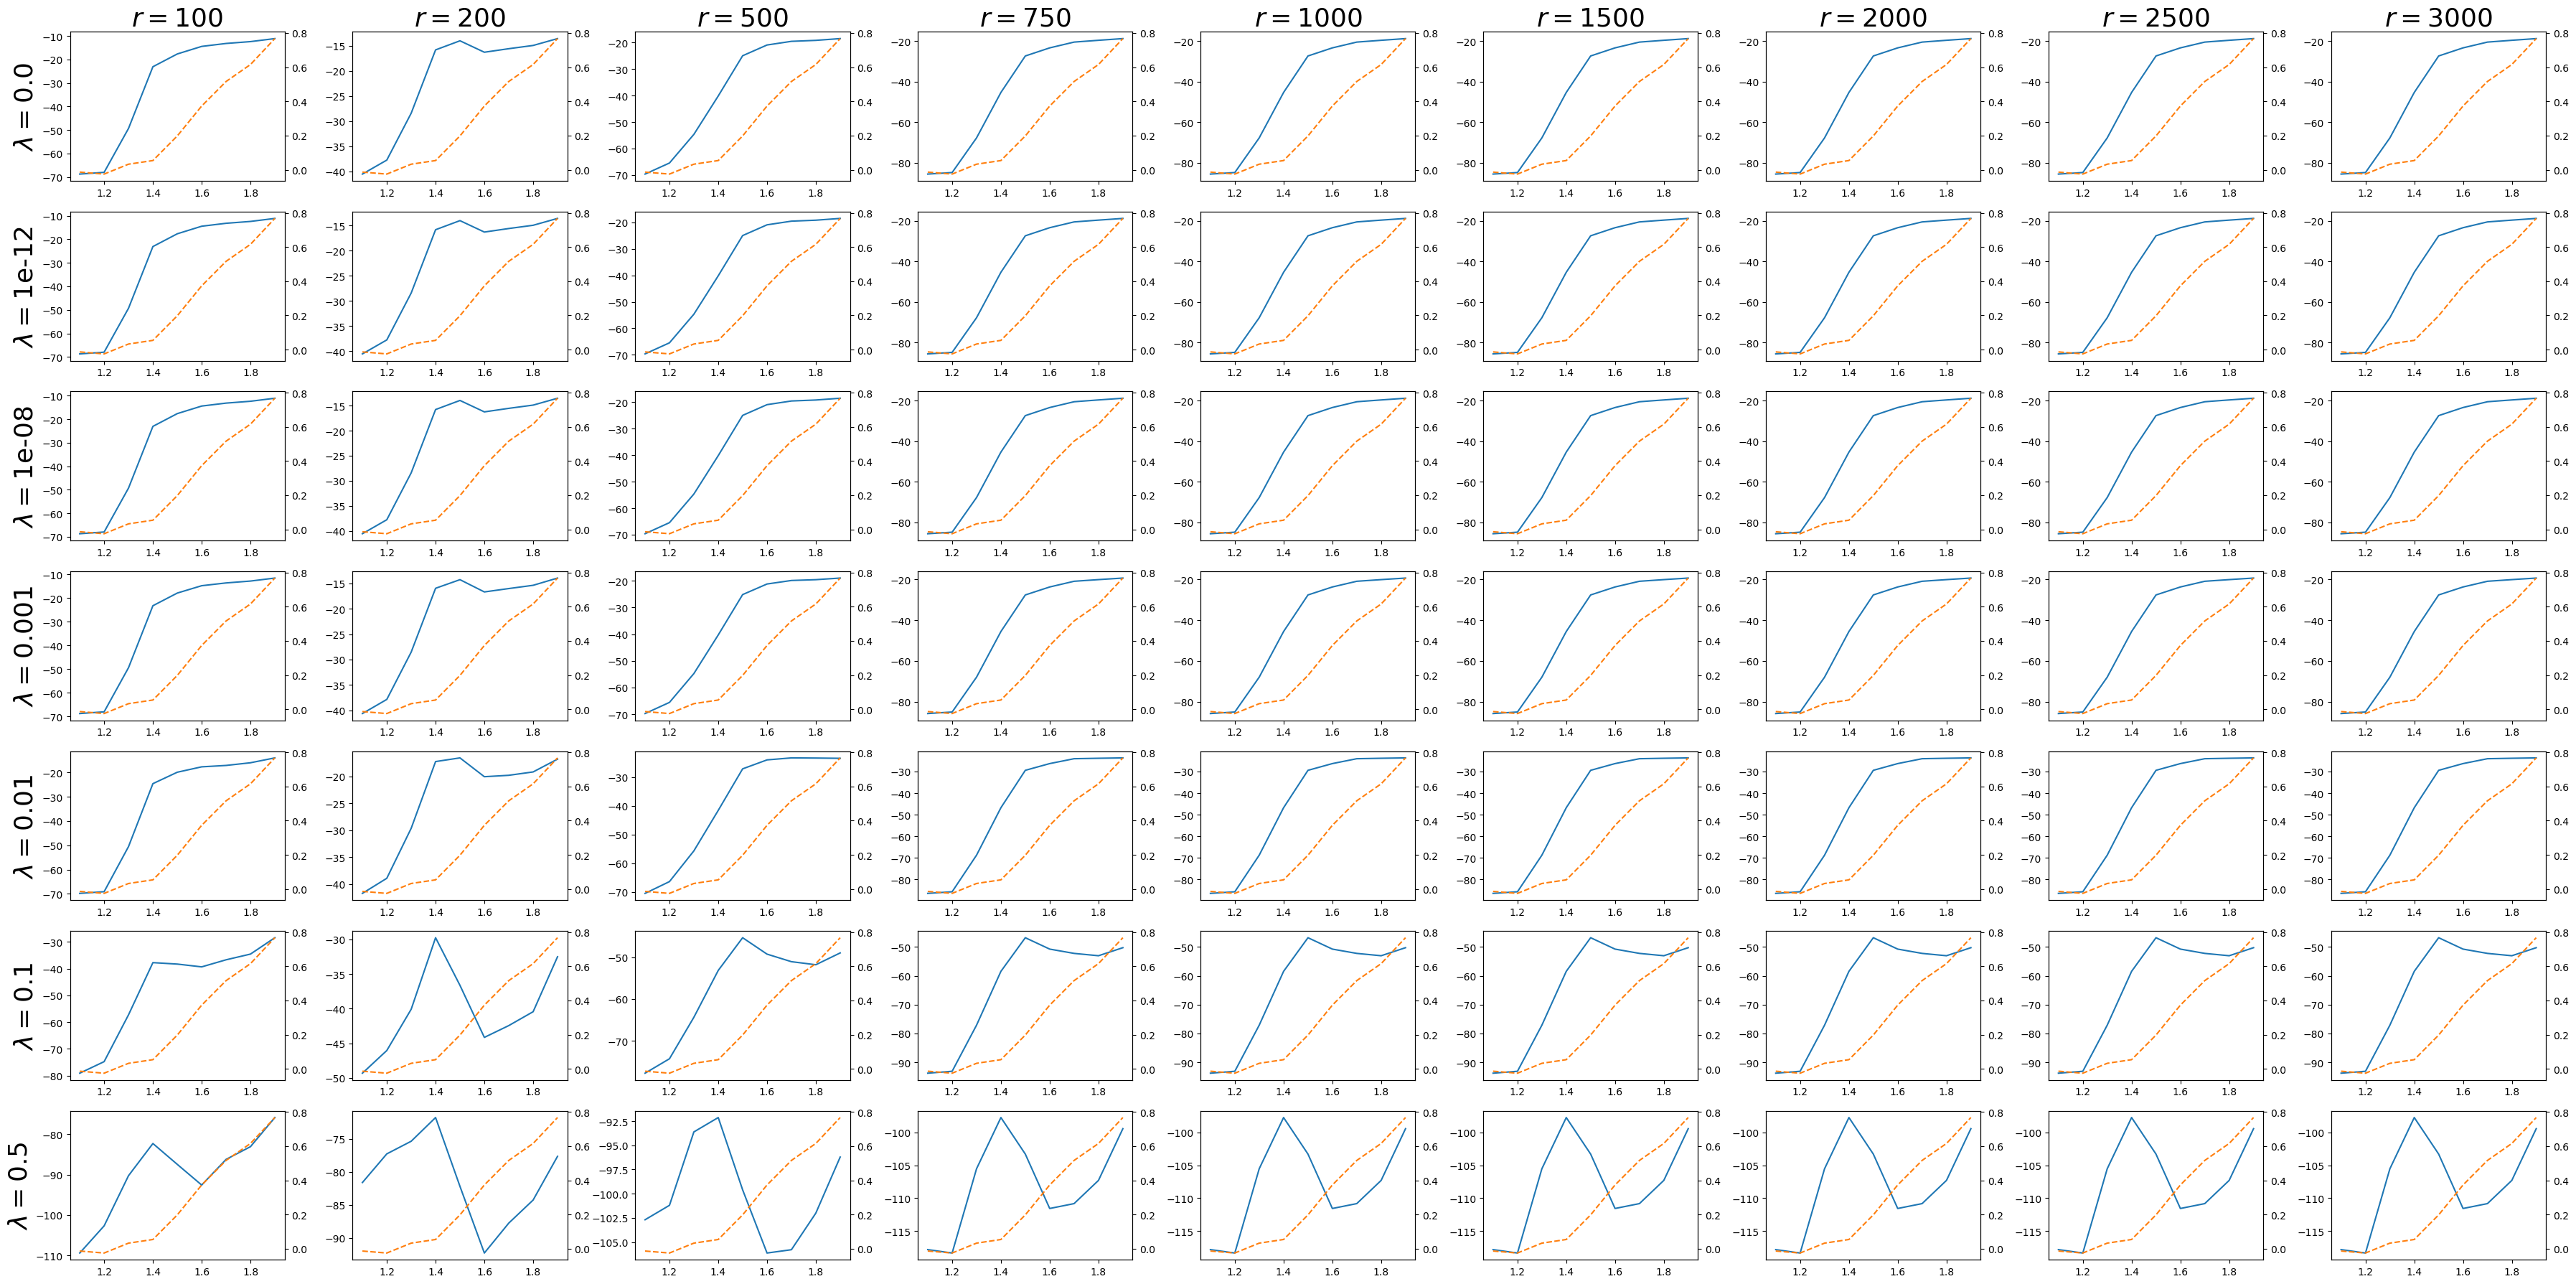

In [357]:
keys = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]
top_percent = 0.1
r_vals = results[keys[0]].r.unique()
lamb_vals = results[keys[0]].lamb.unique()

fig, axs = plt.subplots(len(lamb_vals), len(r_vals), figsize=(36, 18))
for i, r in enumerate(r_vals):
    for j, lamb in enumerate(lamb_vals):
        curve = np.array([results[key][np.logical_and(results[key].r == r, results[key].lamb == lamb)].stability_params.apply(lambda x: x[:int(top_percent*len(x))].mean()).to_numpy()[0] for key in keys])
#         se = np.array([results[key][np.logical_and(results[key].r == r, results[key].lamb == lamb)].stability_params.apply(lambda x: x[:int(top_percent*len(x))].mean()/np.sqrt(int(top_percent*len(x)))).to_numpy()[0] for key in keys])
        ax = axs[j, i]
        ax.plot(keys, curve)
#         ax.fill_between(keys, curve-se, curve+se, color='C0', alpha=0.3)
        ax2 = ax.twinx()
        ax2.plot(keys, [lyaps[key][:1].mean() for key in keys], linestyle='--', c='C1')
#         ax2.plot([lyaps[key][:int(len(lyaps[key])*top_percent)].mean() for key in keys], linestyle='--', c='C1')
        if i == 0:
            ax.set_ylabel(f"$\lambda = ${lamb}", fontsize=26)
        if j == 0:
            ax.set_title("$r = $" + f"{r}", fontsize=26)
plt.tight_layout()
plt.show()

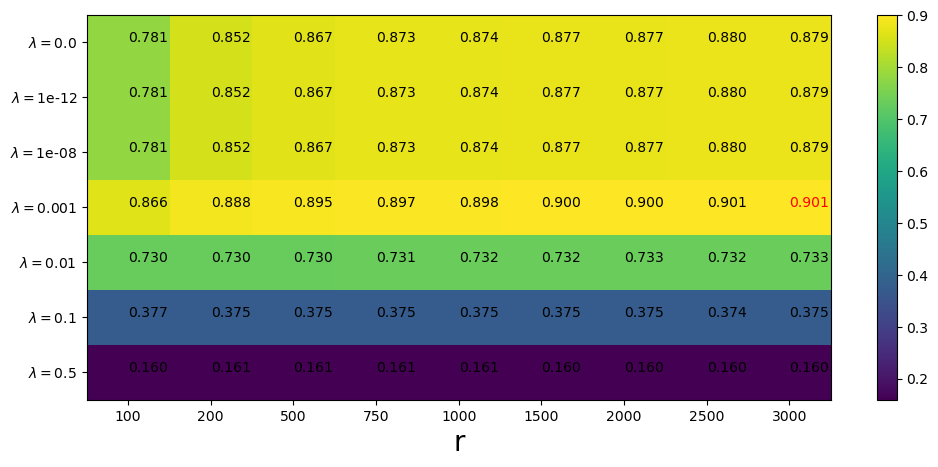

In [277]:
keys = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]
r_vals = results[keys[0]].r.unique()
lamb_vals = results[keys[0]].lamb.unique()

performance_mat = np.zeros((len(r_vals), len(lamb_vals)))
for i, r in enumerate(r_vals):
    for j, lamb in enumerate(lamb_vals):
        curve = [results[key][np.logical_and(results[key].r == r, results[key].lamb == lamb)].ip for key in keys]
        performance_mat[i, j] = np.mean(curve)
        if performance_mat[i, j] < -1:
            performance_mat[i, j] = -1

plt.figure(figsize=(12, 5))
ax = plt.gca()
im = ax.imshow(performance_mat.T, aspect='auto')
plt.xticks(np.arange(len(r_vals)), [f"{r}" for r in r_vals])
plt.xlabel("r", fontsize=20)
plt.yticks(np.arange(len(lamb_vals)), ["$\lambda = $" + f"{lamb}" for lamb in lamb_vals])
ip = performance_mat
max_val = ip.max()
for j in range(ip.shape[0]):
    for i in range(ip.shape[1]):
        if ip[j, i] == max_val:
            c = 'r'
        else:
            c = 'k'
        plt.text(j, i, f"{ip[j, i]:.3f}", color=c)
plt.colorbar(im)
plt.show()

In [309]:
parameter_grid.window_vals[0], parameter_grid.matrix_size_vals[0]

(5000, 550)

In [310]:
explained_variance = {}
for key in tqdm(keys):
    delase = DeLASE(signals[key][2000:2000 + parameter_grid.window_vals[0]], matrix_size=parameter_grid.matrix_size_vals[0], dt=dt, use_torch=True, device='cuda')
    explained_variance[key] = torch.cumsum(delase.S.cpu()**2/((delase.S.cpu()**2).sum()), 0)

  0%|          | 0/9 [00:00<?, ?it/s]

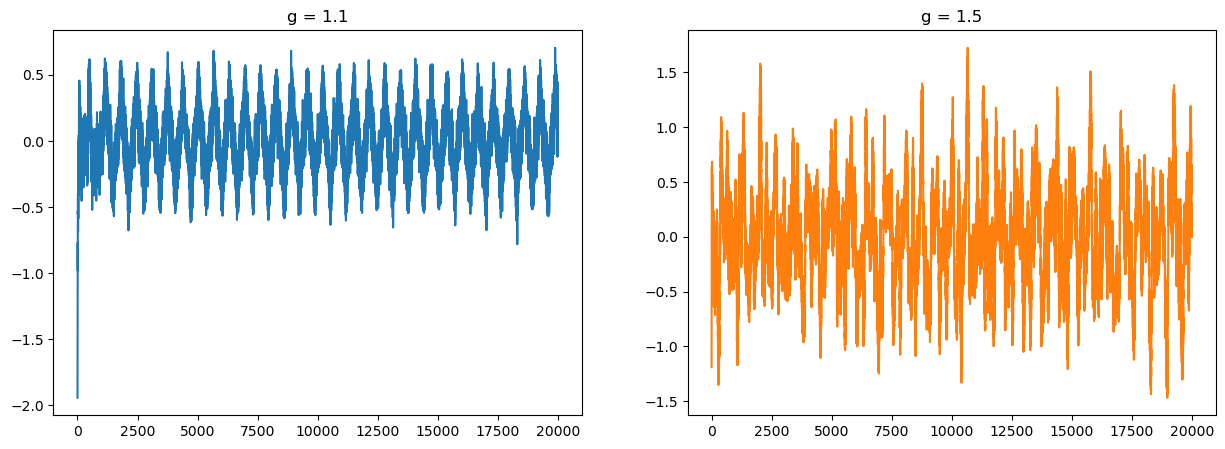

In [311]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(signals[1.1][:, 0])
plt.title('g = 1.1')
plt.subplot(1, 2, 2)
plt.plot(signals[1.5][:, 0], c='C1')
plt.title('g = 1.5')
plt.show()

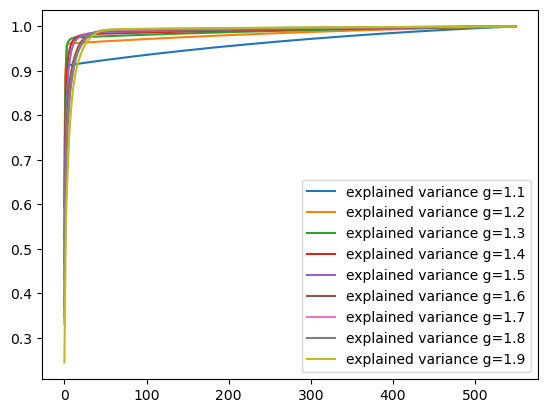

In [312]:
for key in keys:
    plt.plot(explained_variance[key], label=f'explained variance g={key}')
plt.legend()
plt.show()

In [349]:
thresh = 0.99
r = np.max([np.argmax(explained_variance[key] > thresh) for key in keys])

In [350]:
r

441

In [351]:
stability_params = {}
for key in tqdm(keys):
    delase = DeLASE(signals[key][2000:2000 + parameter_grid.window_vals[0]], matrix_size=parameter_grid.matrix_size_vals[0], dt=dt, use_torch=True, device='cuda')
    delase.compute_havok_dmd(r=r, lamb=0)
    delase.compute_jacobians()
    delase.get_stability(max_freq=500, max_unstable_freq=125)
    stability_params[key] = delase.stability_params

  0%|          | 0/9 [00:00<?, ?it/s]

In [352]:
top_percent = 0.3

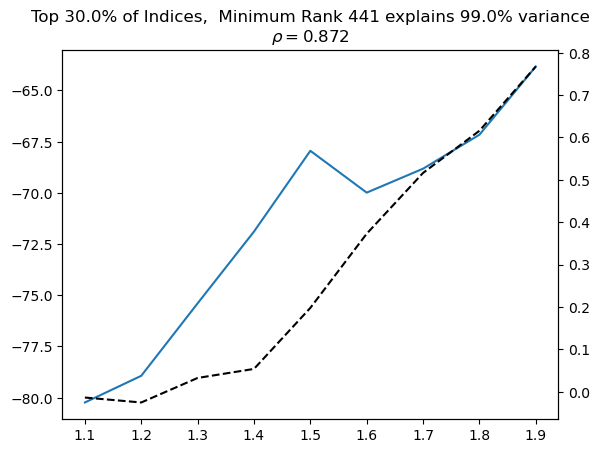

In [353]:
start = 0
end = len(keys)
mean_stab = np.array([stability_params[key][:int(len(stability_params[key])*top_percent)].cpu().mean() for key in keys])
se_stab = np.array([stability_params[key][:int(len(stability_params[key])*top_percent)].cpu().std()/np.sqrt(int(len(stability_params[key])*top_percent)) for key in keys])
plt.plot(keys[start:end], mean_stab[start:end], label=f'mean top {top_percent}')
# plt.fill_between(keys[start:end], mean_stab[start:end] - se_stab[start:end], mean_stab[start:end] + se_stab[start:end], color='C0', alpha=0.3)
ax2 = plt.gca().twinx()
ax2.plot(keys[start:end], [lyaps[key][0] for key in keys][start:end], c='k', linestyle='--', label='')
rho = scipy.stats.pearsonr(mean_stab[start:end], [lyaps[key][0] for key in keys][start:end])[0]
plt.title(f'Top {top_percent*100}% of Indices,  Minimum Rank {r} explains {thresh*100}% variance\n' + r'$\rho = $' + f"{rho:.3f}")
plt.show()

In [188]:
# keys = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]
# top_percent = 0.1
# r_vals = results[keys[0]].r.unique()
# lamb_vals = results[keys[0]].lamb.unique()

# fig, axs = plt.subplots(len(lamb_vals), len(r_vals), figsize=(36, 18), sharey=False)
# for i, r in enumerate(r_vals):
#     for j, lamb in enumerate(lamb_vals):
#         curve = [results[key][np.logical_and(results[key].r == r, results[key].lamb == lamb)].ip for key in keys]
#         ax = axs[j, i]
#         ax.plot(keys, curve)
#         if i == 0:
#             ax.set_ylabel(f"$\lambda = ${lamb}", fontsize=26)
#         if j == 0:
#             ax.set_title("$r = $" + f"{r}", fontsize=26)
#         ax.tick_params(labelsize=23)
# plt.tight_layout()
# plt.show()

# Checking Explained Variance

In [61]:
delase2 = DeLASE(signals[1.5][:10000], matrix_size=3000, dt=dt, use_torch=True, device='cuda')

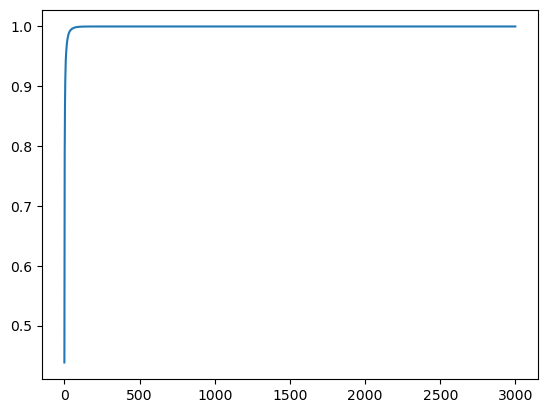

In [38]:
plt.plot(torch.cumsum(delase.S.cpu()**2/((delase.S.cpu()**2).sum()), 0))

In [57]:
delase = DeLASE(signals[1.1][:10000], matrix_size=3000, dt=dt, use_torch=True, device='cuda')

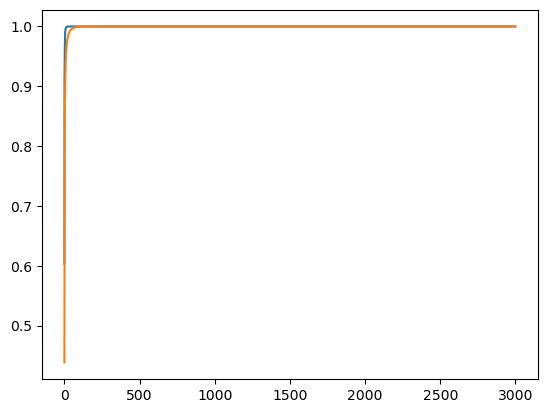

In [62]:
plt.plot(torch.cumsum(delase.S.cpu()**2/((delase.S.cpu()**2).sum()), 0))
plt.plot(torch.cumsum(delase2.S.cpu()**2/((delase2.S.cpu()**2).sum()), 0))
plt.show()

In [65]:
torch.cumsum(delase2.S.cpu()**2/((delase2.S.cpu()**2).sum()), 0)[2000]

tensor(1.0000)

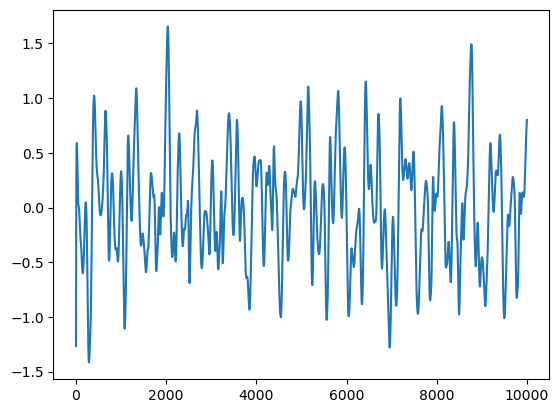

In [59]:
plt.plot(signals[1.5][:10000, 0])

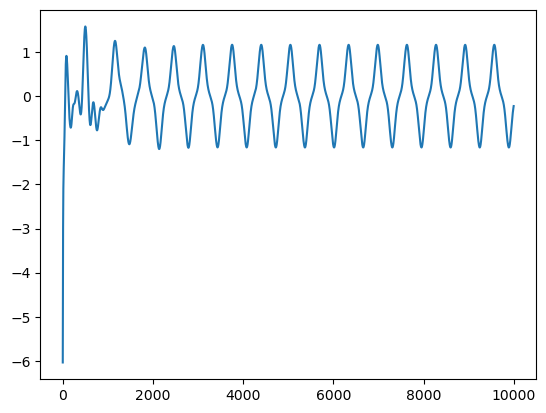

In [60]:
plt.plot(signals[1.1][:10000, 0])

# Simulating Chaotic Networks with Pulse Inputs

In [142]:
dt = 0.001

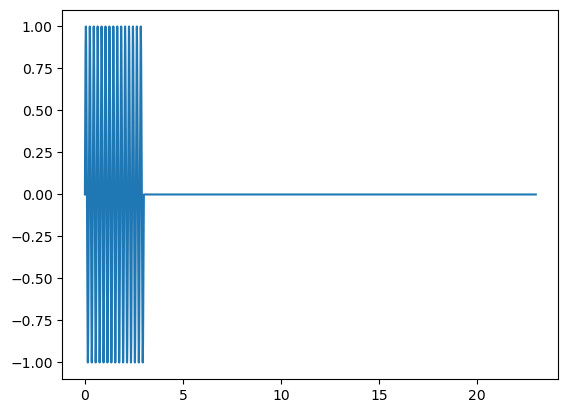

In [143]:
length = 23
I = np.zeros(int(length/dt))
time_vals = np.arange(int(length/dt))*dt
freq = 5
input_duration = 3
def I(t, freq, input_duration):
    if t <= input_duration:
        return np.sin(t*2*np.pi*freq)
    else:
        return 0
plt.plot(time_vals, [I(t, freq, input_duration) for t in time_vals])
plt.show()

In [144]:
B = np.abs(np.random.randn(W.shape[0])*5)
tau = 0.1

In [145]:
def rnn_with_input(t, x, W, tau, g, B, freq, input_duration):
    return (1/tau)*(-x + g*W @ np.tanh(x) + B*I(t, freq, input_duration))

In [146]:
sol = scipy.integrate.solve_ivp(lambda t, x: rnn_with_input(t, x, W=W, tau=tau, g=1.1, B=B, freq=freq, input_duration=input_duration), y0=np.random.randn(W.shape[0]), t_span=[np.min(time_vals), np.max(time_vals)], t_eval=time_vals)

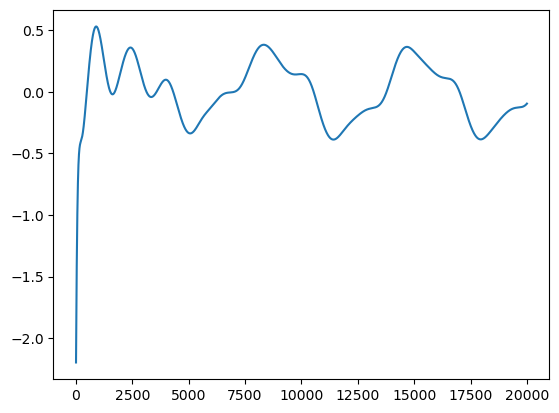

In [147]:
plt.plot(sol.y[0, int(input_duration/dt):])

In [148]:
delase = DeLASE(sol.y[:, int(input_duration/dt):int(input_duration/dt) + 10000].T, matrix_size=3000, use_torch=True, device='cuda')

In [150]:
delase.compute_havok_dmd(r=100, lamb=0)

In [155]:
torch.linalg.matrix_rank(delase.A)

tensor(100, device='cuda:0')

In [156]:
delase.compute_havok_dmd(r=100, lamb=1)

In [157]:
torch.linalg.matrix_rank(delase.A)

tensor(99, device='cuda:0')

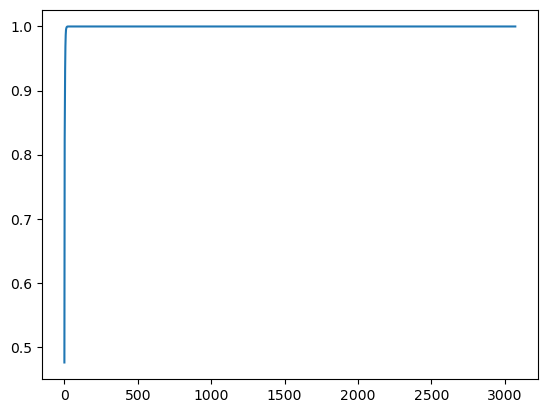

In [149]:
plt.plot(torch.cumsum(delase.S.cpu()**2/((delase.S.cpu()**2).sum()), 0))
plt.show()